# Figueroa LAML HM450 probes clustering analysis

Load subset of probes filtered from Figueroa paper and display the heatmap

In [42]:
library(pheatmap)
library(RColorBrewer)
library(viridis)
library(dplyr)
library(NbClust)
library(factoextra)
library(impute)
source("../R/regressionModel/regressionModel.R")

In [39]:
Figueroa.HM450 <- read.csv('../data/LAML/processed/HM450-imputed-matched.tsv', sep='\t', stringsAsFactor=F, header=F)
HM450 <- data.matrix(Figueroa.HM450[-1,-1])
rownames(HM450) <- Figueroa.HM450[-1,1]
colnames(HM450) <- Figueroa.HM450[1,-dim(Figueroa.HM450)[2]]
head(HM450)
dim(HM450)

,TCGA.AB.2803.03,TCGA.AB.2805.03,TCGA.AB.2806.03,TCGA.AB.2807.03,TCGA.AB.2808.03,TCGA.AB.2810.03,TCGA.AB.2811.03,TCGA.AB.2812.03,TCGA.AB.2813.03,TCGA.AB.2814.03,⋯,TCGA.AB.3000.03,TCGA.AB.3001.03,TCGA.AB.3002.03,TCGA.AB.3005.03,TCGA.AB.3006.03,TCGA.AB.3007.03,TCGA.AB.3008.03,TCGA.AB.3009.03,TCGA.AB.3011.03,TCGA.AB.3012.03
PHF13,-4.004145,-3.794953,-3.9660171,-4.263137,-3.765993,-3.959458,-4.641040,-3.9010464,-4.096595,-4.151743,⋯,-4.1595952,-4.1257503,-3.963623,-4.056794,-4.097540,-3.975794,-4.050068,-4.188130,-3.933027,-3.881537
PHF13,2.892583,2.843739,2.8208039,3.135753,3.251803,2.766626,2.828186,2.5807666,3.114872,3.407122,⋯,2.9309041,2.7480390,3.161449,3.146351,3.052537,3.138275,2.478139,2.571481,2.819024,3.029927
PHF13,4.395918,4.177961,4.4012351,4.384920,3.812857,4.359086,4.137607,0.1850708,4.080237,3.954928,⋯,4.0440522,4.0184496,4.107560,4.531431,4.170725,4.082631,3.770873,4.705069,3.315898,3.851546
PHF13,-5.919172,-5.823179,-5.7430434,-6.102751,-5.457778,-5.860466,-5.782167,-5.5642920,-5.917559,-5.912928,⋯,-5.8078912,-5.5252516,-5.612440,-5.945578,-6.190115,-6.080275,-5.621923,-5.994996,-5.523487,-5.653974
PHF13,-4.285657,-4.338425,-4.4939199,-4.350939,-4.531238,-4.363566,-4.780230,-4.5661233,-4.812903,-4.252939,⋯,-4.2760677,-4.6561792,-4.682878,-4.918769,-4.308473,-4.600140,-4.349466,-4.572726,-4.233375,-4.604978
PHF13,-1.487470,-1.455567,-0.8845531,-1.669851,-1.438268,-1.656870,-1.296417,-2.6029148,-2.324790,-1.445330,⋯,-0.8612598,-0.7783658,-1.714099,-2.510359,-1.974088,-1.748480,-1.676362,-1.043989,-1.075219,-0.733162


[1] 18091   170

In [44]:
sd.probes <- apply(HM450, 1, sd)

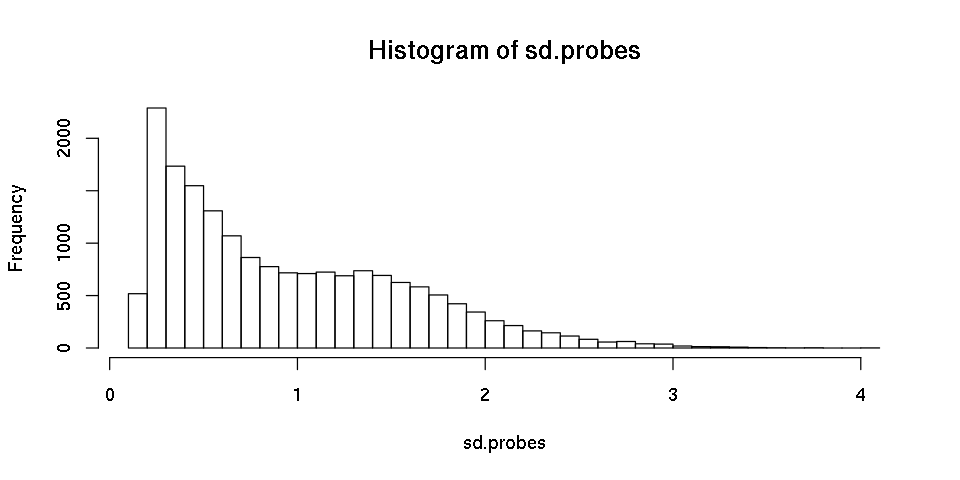

In [45]:
hist(sd.probes, breaks=50)

In [61]:
sum(sd.probes > 1.3)

[1] 5145

## Decide optimal number of clusters
see if the results are similar as on HM27 array (which has 1470 probes) 

In [ ]:
options(repr.plot.width=8, repr.plot.height=4)
nb <- NbClust(data = HM450[unlist(sd.probes)>1.3,], diss = NULL, distance = "euclidean", min.nc = 2, max.nc = 15, method = "ward.D2", index = "all", alphaBeale = 0.1)

In [ ]:
options(repr.plot.width=10, repr.plot.height=4)
fviz_nbclust(nb)

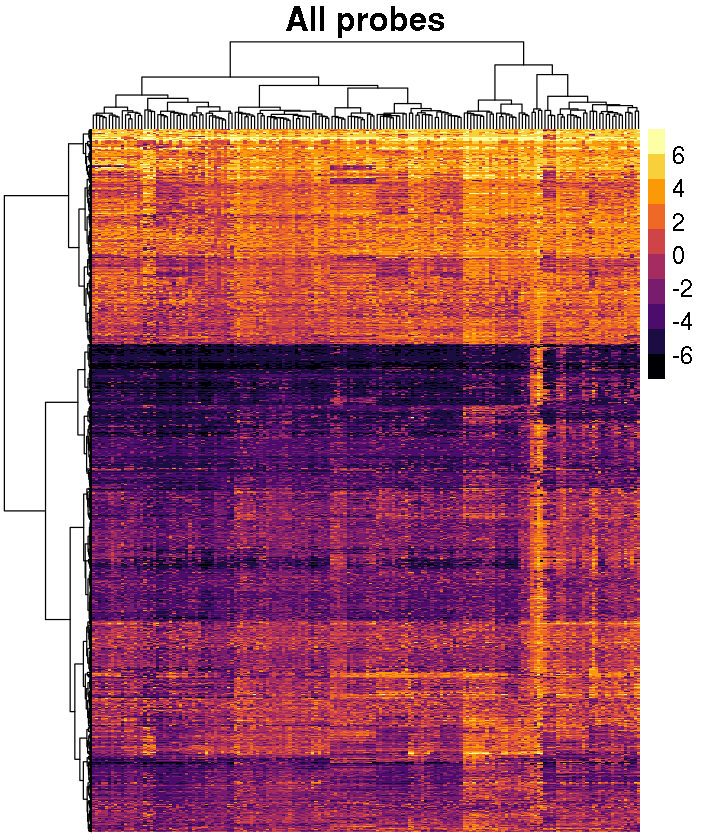

In [62]:
options(repr.plot.width=6, repr.plot.height=7)

res <- pheatmap(
  mat               = HM450[unlist(sd.probes)>1.3,],
  color             = inferno(10),
  border_color      = NA,
  show_colnames     = FALSE,
  show_rownames     = FALSE,
  clustering_method = "ward.D2",
  fontsize          = 14,
  #cutree_rows       = 3,
  main              = "All probes"
)

In [ ]:
res.clust <- cbind(HM450, 
                   cluster = cutree(res$tree_row, k = n))
head(res.clust)

In [ ]:
table(res.clust[,dim(res.clust)[2]])

## Load RNAseq data

In [ ]:
rnaseq.raw <- read.csv('../data/LAML/processed/rnaseq-imputed-matched-filtered.tsv', sep='\t', stringsAsFactor=F, header=F)
rnaseq <- data.matrix(rnaseq.raw[-1, -1])
colnames(rnaseq) <- rnaseq.raw[1, -dim(rnaseq.raw)[2]]
rownames(rnaseq) <- rnaseq.raw[-1, 1]
head(rnaseq)  # predictors

## Compute average methylation level functions and set the training set (compute training set and testing set RMSE)

In [ ]:
findClusterIdx <- function(i) {
    n <- dim(res.clust)[2]
    which(res.clust[,n] == i)
}

In [ ]:
computeAverage <- function(idx) {
    n <- dim(res.clust)[2]
    cluster.probes <- res.clust[idx, -n]
    cbind(apply(cluster.probes, 2, mean), apply(cluster.probes, 2, sd))
}

In [ ]:
set.seed(1)
train.idx <- sample(colnames(rnaseq), round(dim(rnaseq)[2] * 0.75, 0)) # 75 % as training set

In [ ]:
rnaseq.train <- rnaseq[, colnames(rnaseq) %in% train.idx]
head(rnaseq.train)

In [ ]:
findIdx <- function(gene) {
    which(rownames(rnaseq) %in% gene)
}
FindIdx <- Vectorize(findIdx)

In [ ]:
predict.vbsr <- function(vbsr.fit, new.rnaseq, y.true) {
    alpha <- vbsr.fit$alpha
    beta <- vbsr.fit$beta
    y.hat <- alpha + t(new.rnaseq) %*% matrix(beta, ncol=1)
    rmse <- sqrt(mean((y.true - y.hat)^2))
    return(rmse)
}

In [ ]:
n <- dim(HM450)[2]
plotCluster <- function(i) {
    set.seed(1)
    idx <- findClusterIdx(i)
    cluster.probes <- HM27[idx, -n]
    train.rnaseq.idx <- colnames(rnaseq) %in% train.idx
    train.hm450.idx <- colnames(HM450) %in% train.idx
    
    cluster.mean <- computeAverage(findClusterIdx(i))
    
    model.fit <- vbsr(y=cluster.mean[train.hm450.idx], X=t(rnaseq[,train.rnaseq.idx]), 
                      family='normal', eps=5e-15, maxit=10^4, post=0.5)
    rmse <- predict.vbsr(model.fit, rnaseq[,-train.rnaseq.idx], cluster.mean[-train.hm450.idx])
    
    post <- model.fit$post
    significant.idx <- post > 0.3
    coef.names <- rownames(rnaseq.train)[significant.idx]
    coef.significant <- model.fit$beta[significant.idx]
    res1 <- data.frame(gene=coef.names, coef=coef.significant)
    print(res1)
    ModuleHeatmap(t(cluster.probes), cluster.mean[,1], t(rnaseq[as.numeric(FindIdx(res1$gene)), ] * as.vector(sign(res1$coef))), center=T, scale=T)
    return(rmse)
}

## VBSR analysis

In [ ]:
for (i in seq(n)) {
    plotCluster(i)
}